# План домашних заданий


- Описание задачи и знакомство с данными
- Домашнее задание 1. Генерация и фильтрация признаков
- Домашнее задание 2. Прогноз времени и вида поломки машин, настройка ML-модели
- Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков
- Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`
- Домашнее задание 4. Блендинг
- Домашнее задание 5. Парсинг внешних данных и оптимизация памяти
- Отправка финального решения на лидерборд на Kaggle

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_columns', None)

# <center id="part0"> Описание задачи

**Предыстория:**  мы работаем с каршеринговой компанией, которая управляет крупным автопарком машин. Наша цель — предотвратить длительные периоды простоя машин из-за поломок через своевременное обслуживание и ремонт.


**Идея для решения проблемы:** создать приоритизированный список обхода машин. Этот список поможет технической бригаде сосредоточиться на автомобилях, которые наиболее вероятно выйдут из строя в ближайшее время.


**Как компания решает задачу:**

* Собирает данные о поездках и состоянии машин до поломок.

* Нанимает Data Scientist, чтобы он смог использовать эти данные для анализа и прогнозирования характера поломок.

**Важный момент**: задачи этого специалиста (Data Scientist) предстоит выполнять вам.

## <center> Знакомство с данными

### Информация про машины с таргетом (основной датасет)

In [2]:
car_train = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_train.csv')
car_train.sample(5)

,car_id,model,car_type,fuel_type,car_rating,year_to_start,riders,year_to_work,target_reg,target_class
1147,r-1938611y,Smart ForFour,economy,petrol,5.36,2014,61809,2020,38.14,gear_stick
2131,Y-2287594M,MINI CooperSE,business,electro,6.00,2015,73789,2019,66.59,engine_overheat
2117,x-1749702B,VW Polo,economy,petrol,4.54,2011,576,2016,41.99,gear_stick
681,c21762167i,Smart ForFour,economy,petrol,3.48,2013,36104,2017,52.73,engine_check
914,o-1530462a,Renault Sandero,standart,petrol,5.16,2012,29338,2019,34.18,gear_stick


- `car_id` — идентификатор машины
- `model` / `car_type` / `fuel_type` — марка, класс и тип топлива машины
- `car_rating` / `riders` — общий рейтинг и общее число поездок к концу 2021 года
- `year_to_start` / `year_to_work` — год выпуска машины и год начала работы в автопарке
- `target_reg` — количество дней до поломки
- `target_class` — класс поломки (всего 9 видов)

### Информация про поездки

In [3]:
rides_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/rides_info.csv')
rides_info.sample(5)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
11696,A61240019M,A19893808P,Q1a,2020-01-21,5.07,10,73,40,74.000000,0,445.390975,0,7.617050,-21.664
128866,A12040218s,J-1137633W,v1Z,2020-02-26,0.35,58,805,50,154.835524,2,2615.927988,0,-3.105903,-1.869
533762,d17074473m,l21588657Q,Y1V,2020-02-25,4.26,55,600,51,80.000000,1,2380.041450,0,11.876422,6.415
673178,y76122393s,v-7924266I,x1m,2020-03-18,2.52,45,489,38,58.387300,0,1541.549805,0,24.390676,-10.198
620302,I73140359M,r80685540h,b1o,2020-03-29,3.92,56,667,47,73.000000,2,1585.851609,0,-7.994164,32.342


- `user_id` / `car_id` / `ride_id` — идентификаторы водителя, машины, поездки соответственно
- `ride_date` / `rating` — дата поездки и рейтинг, поставленный водителем
- `ride_duration` / `distance` / `ride_cost` —  длительность (время),  пройденное расстояние, стоимость поездки
- `speed_avg` / `speed_max` — средняя и максимальная скорости поездки соответственно
- `stop_times` / `refueling` — количество остановок (паузы) и флаг: была ли дозаправка
- `user_ride_quality` — оценка манеры вождения водителя машины, определенная скоринговой ML-системой сервиса
- `deviation_normal` — общий показатель датчиков о состоянии машины, относительно эталонных показателей (нормы)

### Информация про водителей

In [4]:
driver_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/driver_info.csv')
driver_info.sample(5)

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
6858,21,8.8,1450,8.0,o21421875e,1,2018-8-3
12608,32,8.7,805,12.0,H40006180U,1,2020-9-12
13178,39,7.4,770,7.0,z86709547G,0,2019-4-24
4670,25,7.9,352,13.0,L76217336z,1,2019-8-14
2570,22,7.1,502,7.0,C21994917Z,1,2019-7-6


- `user_id` / `age` / `sex` — идентификатор, возраст и пол водителя, соответственно
- `user_rating` — общий рейтинг пользователя за все поездки к концу 2021 года
- `user_rides` — общее количество поездок к концу 2021 года
- `user_time_accident` — число инцидентов (это могли быть аварии/штрафы/эвакуация машины)  
- `first_ride_date` — дата первой поездки

### Информация про ремонт машин

In [5]:
fix_info = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/fix_info.csv')
fix_info.sample(5)

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
70662,Z-2109687y,PB,2020-7-3 13:10,reparking,1.0,31
111303,F-1408164F,CH,2019-5-27 17:58,repair,5.0,10
106158,f-1042769Z,LJ,2020-9-5 5:48,repair,4.4,8
69391,t11042597E,VP,2020-5-8 14:55,repair,3.9,6
53799,p-1097843f,YH,2018-8-12 3:0,refuel,1.0,24


- `worker_id` / `car_id` — идентификатор работника и машины
- `work_type` / `work_duration` — тип и длительность (в часах) проводимой работы
- `destroy_degree` — степень износа/поврежденности машины в случае поломки
- `fix_date` — время начала ремонта (снятия машины с линии)

# Домашнее задание 1. Генерация и фильтрация признаков

<center> <img src="https://ucarecdn.com/bf4c772d-b67a-42ae-a48b-cfd83910b0a2/" width=700>

<div class="alert alert-info">

**Цель блока** — сгенерировать признаки из дополнительных датасетов и добавить их к основному датасету, произвести фильтрацию признаков.

    
## Задание 1. Генерация признаков из дополнительных датасетов (6 баллов)

<div class="alert alert-info">

1. Возьмите датасет `rides_info` с информацией о поездках и проведите группировку по каждой машине отдельно.

2. Для каждой машины (то есть для каждого `car_id`) подсчитайте несколько признаков:
  - минимальный рейтинг за все поездки;
  - средний рейтинг за все поездки;
  - общее количество километров, которое машина проехала;
  - максимальная скорость;
  - общее количество поездок для каждой машины.

3. Добавьте минимум 3 признака на свой выбор.

4. Сделайте соединение таблиц — вспомните про методы соединения и выберите подходящий для этого случая.

5. Подключите информацию про водителей (`driver_info`) и про ремонт машин (`fix_info`). Добавьте минимум 3 любых признака с каждого датасета.


<h4> Критерии оценивания </h4>
    
- Добавлены 5 обязательных и минимум 3 любых признака из датасета `rides_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `driver_info` — 2 балла.
- Добавлены минимум 3 любых признака из датасета `fix_info` — 2 балла.

</div>

<div class="alert alert-success">
    
<h4> Советы по Feature Engineering</h4>
    
- Начинайте с сырых данных.
- Используйте все доступные данные. Покрывайте признаками всю имеющуюся информацию в данных.
- Формулируйте предположения: от чего зависит таргет?
- Смотрите визуально на классы/ошибки и делайте предположения. Какие полезны?
- Помните, что слишком много признаков может быть вредно. Потом придется отфильтровывать.
    
<h4> Полезные источники </h4>
    
- Занятие про Feature Engineering.
- Занятие про Feature Selection.
- [Max Kuhn and Kjell Johnson. Feature Engineering and Selection: A Practical Approach for Predictive Models](http://www.feat.engineering/).

### Создание признаков и объединение данных

Набор данных должен содержать только те признаки, которые позволят находить по задаче необходимые свойства, а точнее построить модели, способные решать задачи классификации, прогноза, и другого анализа. 

Итак, дано: 

3 набора данных у которых есть общие id поля. Разумнее их объединить сначала, что в целом получился у нас понятный датасет и мы могли сразу убрать мало интересующие нас признаки. 


In [28]:
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [22]:
rides_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739500 entries, 0 to 739499
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   user_id            739500 non-null  object 
 1   car_id             739500 non-null  object 
 2   ride_id            739500 non-null  object 
 3   ride_date          739500 non-null  object 
 4   rating             739500 non-null  float64
 5   ride_duration      739500 non-null  int64  
 6   ride_cost          739500 non-null  int64  
 7   speed_avg          739500 non-null  int64  
 8   speed_max          736139 non-null  float64
 9   stop_times         739500 non-null  int64  
 10  distance           739500 non-null  float64
 11  refueling          739500 non-null  int64  
 12  user_ride_quality  736872 non-null  float64
 13  deviation_normal   739500 non-null  float64
dtypes: float64(5), int64(5), object(4)
memory usage: 79.0+ MB


In [23]:
rides_info.describe()

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
count,739500.000000,739500.000000,7.395000e+05,739500.000000,736139.000000,739500.000000,7.395000e+05,739500.000000,736872.000000,739500.000000
mean,4.471255,1669.619079,2.093108e+04,47.012270,83.787431,1.337385,7.839567e+04,0.000004,-0.273648,-1.341434
std,2.130867,6356.635586,8.731537e+04,12.690333,29.642707,2.369775,3.158147e+05,0.002014,11.657122,19.581792
min,0.000000,2.000000,7.000000e+00,25.000000,27.900000,0.000000,1.843634e+00,0.000000,-65.776864,-126.883000
25%,3.120000,27.000000,2.980000e+02,38.000000,64.000000,0.000000,7.925952e+02,0.000000,-6.975054,-9.358000
50%,4.470000,44.000000,5.050000e+02,46.000000,75.275957,1.000000,1.452544e+03,0.000000,0.074098,0.000000
75%,5.830000,69.000000,8.880000e+02,52.000000,97.000000,2.000000,2.247795e+03,0.000000,6.461507,7.539250
max,10.000000,43956.000000,2.007346e+06,100.000000,209.982840,23.000000,3.606051e+06,1.000000,69.574650,98.743000


In [13]:
driver_info.head()

,age,user_rating,user_rides,user_time_accident,user_id,sex,first_ride_date
0,27,9.0,865,19.0,l17437965W,1,2019-4-2
1,46,7.9,2116,11.0,Z12362316j,0,2021-11-19
2,59,7.8,947,4.0,g11098715c,0,2021-1-15
3,37,7.0,18,4.0,U12618125q,0,2019-11-20
4,39,8.2,428,7.0,A14375829B,0,2019-7-23


In [24]:
driver_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15153 entries, 0 to 15152
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 15153 non-null  int64  
 1   user_rating         15153 non-null  float64
 2   user_rides          15153 non-null  int64  
 3   user_time_accident  14182 non-null  float64
 4   user_id             15153 non-null  object 
 5   sex                 15153 non-null  int64  
 6   first_ride_date     15153 non-null  object 
dtypes: float64(2), int64(3), object(2)
memory usage: 828.8+ KB


In [25]:
driver_info.describe()

,age,user_rating,user_rides,user_time_accident,sex
count,15153.000000,15153.000000,15153.000000,14182.000000,15153.000000
mean,33.581073,8.109345,871.015442,10.129601,0.499967
std,9.919271,0.668246,573.512378,8.867482,0.500016
min,18.000000,5.800000,0.000000,0.000000,0.000000
25%,25.000000,7.700000,421.000000,4.000000,0.000000
50%,33.000000,8.100000,876.000000,9.000000,0.000000
75%,41.000000,8.600000,1145.000000,14.000000,1.000000
max,63.000000,10.000000,3316.000000,86.000000,1.000000


In [14]:
fix_info.head()

,car_id,worker_id,fix_date,work_type,destroy_degree,work_duration
0,P17494612l,RJ,2020-6-20 2:14,reparking,8.0,49
1,N-1530212S,LM,2020-2-9 20:25,repair,10.0,48
2,B-1154399t,ND,2019-8-24 7:1,reparking,1.0,27
3,y13744087j,PG,2019-8-10 9:29,reparking,1.0,28
4,F12725233R,YC,2020-11-12 5:22,refuel_check,8.0,47


In [26]:
fix_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146000 entries, 0 to 145999
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   car_id          146000 non-null  object 
 1   worker_id       146000 non-null  object 
 2   fix_date        146000 non-null  object 
 3   work_type       146000 non-null  object 
 4   destroy_degree  146000 non-null  float64
 5   work_duration   146000 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [27]:
fix_info.describe()

,destroy_degree,work_duration
count,146000.000000,146000.000000
mean,3.510022,26.144527
std,2.752983,12.642266
min,1.000000,1.000000
25%,1.000000,20.000000
50%,3.200000,26.000000
75%,5.500000,31.000000
max,10.000000,74.000000


Проведем группировку данных для каждой машины
- минимальный рейтинг за все поездки;
- средний рейтинг за все поездки;
- общее количество километров, которое машина проехала;
- максимальная скорость;
- общее количество поездок для каждой машины.
+ +общая заправка, общая стоимость поездок и общее количество остановок. 

In [30]:
aggregated_data = rides_info.groupby('car_id').agg(min_rating=pd.NamedAgg(column='rating', aggfunc='min'),
    avg_rating=pd.NamedAgg(column='rating', aggfunc='mean'),
    total_distance=pd.NamedAgg(column='distance', aggfunc='sum'),
    max_speed=pd.NamedAgg(column='speed_max', aggfunc='max'),
    total_stop_times=pd.NamedAgg(column='stop_times', aggfunc='sum'),
    total_refueling=pd.NamedAgg(column='refueling', aggfunc='sum'),
    total_ride_cost=pd.NamedAgg(column='ride_cost', aggfunc='sum'),                                            
    total_trips=pd.NamedAgg(column='ride_id', aggfunc='count')).reset_index()

In [31]:
aggregated_data

,car_id,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips
0,A-1049127W,0.10,4.255172,1.125753e+07,179.729652,142,0,2645050,174
1,A-1079539w,0.10,4.088046,1.912765e+07,184.505566,144,0,4699301,174
2,A-1162143G,0.10,4.662299,2.995194e+06,180.000000,721,0,800344,174
3,A-1228282M,0.10,4.225172,1.793685e+07,182.446070,132,0,4764037,174
4,A-1339912r,0.10,4.690115,1.202552e+07,152.000000,155,0,2816285,174
...,...,...,...,...,...,...,...,...,...
4245,z73688663a,0.10,4.808448,1.113943e+07,165.000000,129,0,2708689,174
4246,z73740510r,0.28,4.699655,7.215961e+06,117.397405,622,0,2155613,174
4247,z86911952C,0.00,4.430977,2.135104e+07,173.428116,136,0,4697507,174
4248,z91353693Z,0.10,5.326092,1.614384e+07,106.089167,139,0,4834945,174


In [ ]:
//сколько дней произошло с момента превой поездки до аварии 

In [32]:
rides_info.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.246920,0,1.115260,2.909
1,H41298704y,A-1049127W,T1U,2020-01-01,6.91,8,59,36,93.000000,1,197.520662,0,1.650465,4.133
2,v88009926E,A-1049127W,g1p,2020-01-02,6.01,20,315,61,81.959675,0,1276.328206,0,2.599112,2.461
3,t14229455i,A-1049127W,S1c,2020-01-02,0.26,19,205,32,128.000000,0,535.680831,0,3.216255,0.909
4,W17067612E,A-1049127W,X1b,2020-01-03,1.21,56,554,38,90.000000,1,1729.143367,0,2.716550,-1.822


In [33]:
data = pd.merge(rides_info, aggregated_data, on='car_id')

In [35]:
data = pd.merge(data, fix_info, on='car_id')

In [36]:
data = pd.merge(data, driver_info, on='user_id')

In [37]:
data.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'total_trips', 'worker_id',
       'fix_date', 'work_type', 'destroy_degree', 'work_duration', 'age',
       'user_rating', 'user_rides', 'user_time_accident', 'sex',
       'first_ride_date'],
      dtype='object')

In [38]:
data.head()

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips,worker_id,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,OO,2020-10-14 14:0,reparking,1.0,36,18,8.0,228,9.0,1,2019-9-16
1,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,SV,2019-6-27 16:56,refuel_check,1.0,31,18,8.0,228,9.0,1,2019-9-16
2,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,ZF,2019-5-9 16:51,refuel_check,1.0,32,18,8.0,228,9.0,1,2019-9-16
3,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,TY,2019-7-27 0:13,repair,7.5,44,18,8.0,228,9.0,1,2019-9-16
4,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,YV,2020-11-24 18:39,repair,5.9,23,18,8.0,228,9.0,1,2019-9-16


### Идеи для новых признаков

1.   Например, время которое прошло между первой поездкой и аварией
2.   Сколько заработала машина с учетом ремонта
3.   Средний ущерб для машины (максимальный, минимальный) 



* `feature_min_max_diff` — разница между максимальным и минимальным значениями `deviation_normal` для каждой машины
* `feature_corner` — угол наклона по признаку `user_ride_quality` для каждой машины
* `feature_mean` — среднее значение `deviation_normal` для каждой машины
* `feature_shift` — точка перегиба/сдвига для `deviation_normal`
* `feature_start` — значение точки старта для `deviation_normal`
* `feature_nans` — сумма пропусков для столбца `...` для каждой машины
* `feature_quant` — `X %` квантиль для столбца `...` для каждой машины

Подумайте, какие из признаков могут оказаться самыми полезными?

На этот вопрос можно будет ответить, когда проверятся все гипотезы. Сначала поищем в том что есть. 

## Задание 2. Применение методов фильтрации признаков (4 балла)

<center> <img src="https://ucarecdn.com/d1b4bc78-fd04-44fb-bdbf-0a63355b7384/" width=700>

1. Выберите и примените любые 3 (можно и больше) метода фильтрации, которые указаны выше или в ноутбуке по фильтрации из полезных ссылок.
2. Проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- Применены методы фильтрации — 1 балл за каждый метод, максимум 3 балла.
- Сделаны выводы на основе примененных методов —1 балл.
</div>

### Советы по Feature Selection

<div class="alert alert-info">

<h3><center>Зачем отбирать признаки</center></h3>
    
**Основные причины**:
    
- Главная причина: с увеличением количества признаков часто падает точность предсказания модели, а некоторые модели и вовсе перестают адекватно работать. Так происходит, если в данных большое количество мусорных фичей (почти не коррелирующих с таргетом).

- Если фичей очень много, то данные перестают помещаться в память и существенно увеличивают время обучения модели, особенно если мы тестируем несколько алгоритмов или ансамбль. Также важно учитывать, что платформы имеют ограничения на длительность одной сессии (в Kaggle — 12 часов) и лимиты по потребляемой памяти.

- Даже если точность не снижается, есть риск, что модель опирается на шумные фичи, что снизит стабильность прогноза на приватной выборке.


<b>Что удалить сразу:</b>
    
- константы;
- уникальные значения (в том числе в тесте; как правило, это ID-шники по типу `car_id`).
    
<b>Какие методы использовать:</b>
    
- `Линейная корреляция`.
- `Phik` — тоже корреляция, но на стероидах ([туториал на Medium](https://towardsdatascience.com/phik-k-get-familiar-with-the-latest-correlation-coefficient-9ba0032b37e7)).
- `Permutation importance` (из `scikit-learn`).
- `SHAP values` (из библиотеки `shap`).
- `CatBoost Feature Selection` (рекурсивные методы).
    

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25404000 entries, 0 to 25403999
Data columns (total 33 columns):
 #   Column              Dtype  
---  ------              -----  
 0   user_id             object 
 1   car_id              object 
 2   ride_id             object 
 3   ride_date           object 
 4   rating              float64
 5   ride_duration       int64  
 6   ride_cost           int64  
 7   speed_avg           int64  
 8   speed_max           float64
 9   stop_times          int64  
 10  distance            float64
 11  refueling           int64  
 12  user_ride_quality   float64
 13  deviation_normal    float64
 14  min_rating          float64
 15  avg_rating          float64
 16  total_distance      float64
 17  max_speed           float64
 18  total_stop_times    int64  
 19  total_refueling     int64  
 20  total_ride_cost     int64  
 21  total_trips         int64  
 22  worker_id           object 
 23  fix_date            object 
 24  work_type           ob

In [47]:
data.head(2)

,user_id,car_id,ride_id,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,total_trips,worker_id,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
0,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,OO,2020-10-14 14:0,reparking,1.0,36,18,8.0,228,9.0,1,2019-9-16
1,o52317055h,A-1049127W,b1v,2020-01-01,4.95,21,268,36,113.548538,0,514.24692,0,1.11526,2.909,0.1,4.255172,1.125753e+07,179.729652,142,0,2645050,174,SV,2019-6-27 16:56,refuel_check,1.0,31,18,8.0,228,9.0,1,2019-9-16


In [48]:
#Удаляем константы из датасета
constant_columns = data.columns[data.nunique() <= 1]
data = data.drop(columns=constant_columns)

In [49]:
data.columns

Index(['user_id', 'car_id', 'ride_id', 'ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'worker_id', 'fix_date',
       'work_type', 'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date'],
      dtype='object')

In [51]:
#Удаляем колонки с id
data = data [['ride_date', 'rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 'fix_date',
       'work_type', 'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident', 'sex', 'first_ride_date']]

In [59]:
data.tail(5)

,ride_date,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,fix_date,work_type,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident,sex,first_ride_date
25403995,2020-03-26,3.82,205,2660,43,104.0,15,2336.646989,0,16.533491,0.835,0.1,4.625,1.169236e+07,191.452313,649,0,3144445,2020-4-25 12:17,repair,5.9,15,32,9.2,120,16.0,1,2020-1-11
25403996,2020-03-26,3.82,205,2660,43,104.0,15,2336.646989,0,16.533491,0.835,0.1,4.625,1.169236e+07,191.452313,649,0,3144445,2020-2-12 14:20,refuel,1.0,35,32,9.2,120,16.0,1,2020-1-11
25403997,2020-03-26,3.82,205,2660,43,104.0,15,2336.646989,0,16.533491,0.835,0.1,4.625,1.169236e+07,191.452313,649,0,3144445,2019-2-20 2:4,refuel_check,1.0,23,32,9.2,120,16.0,1,2020-1-11
25403998,2020-03-26,3.82,205,2660,43,104.0,15,2336.646989,0,16.533491,0.835,0.1,4.625,1.169236e+07,191.452313,649,0,3144445,2019-8-10 17:59,refuel_check,10.0,58,32,9.2,120,16.0,1,2020-1-11
25403999,2020-03-26,3.82,205,2660,43,104.0,15,2336.646989,0,16.533491,0.835,0.1,4.625,1.169236e+07,191.452313,649,0,3144445,2020-5-12 6:40,reparking,1.0,21,32,9.2,120,16.0,1,2020-1-11


In [60]:
numeric_columns = ['rating', 'ride_duration',
       'ride_cost', 'speed_avg', 'speed_max', 'stop_times', 'distance',
       'refueling', 'user_ride_quality', 'deviation_normal', 'min_rating',
       'avg_rating', 'total_distance', 'max_speed', 'total_stop_times',
       'total_refueling', 'total_ride_cost', 
       'destroy_degree', 'work_duration', 'age', 'user_rating',
       'user_rides', 'user_time_accident']
categorial_columns = ['work_type', 'sex']
date_columns = ['ride_date', 'fix_date', 'first_ride_date']

In [61]:
correlation_matrix = data[numeric_columns].corr()

TypeError: sort_values() missing 1 required positional argument: 'by'

<AxesSubplot:>

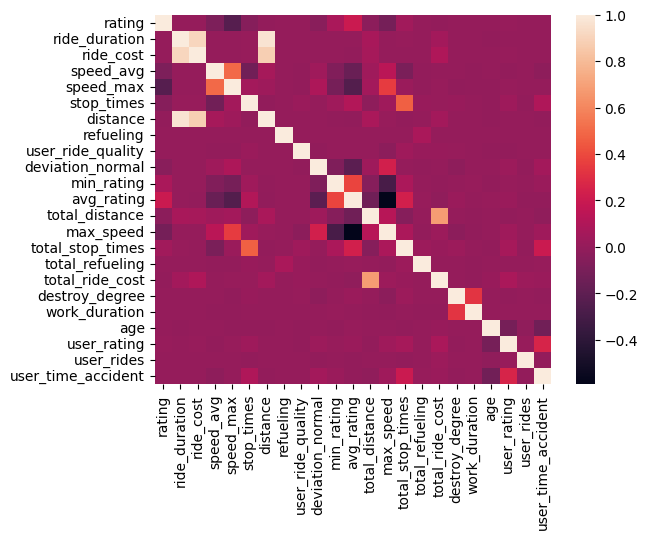

In [63]:
sns.heatmap(correlation_matrix)

In [65]:
correlation_matrix

,rating,ride_duration,ride_cost,speed_avg,speed_max,stop_times,distance,refueling,user_ride_quality,deviation_normal,min_rating,avg_rating,total_distance,max_speed,total_stop_times,total_refueling,total_ride_cost,destroy_degree,work_duration,age,user_rating,user_rides,user_time_accident
rating,1.000000,-0.001248,-0.001021,-0.085969,-0.235871,-0.054392,-0.006362,0.001243,0.000048,-0.042721,0.075672,0.197967,-0.027076,-0.117276,0.046365,0.001671,-0.003294,0.003539,0.000917,0.001603,0.004885,-0.000670,-0.000125
ride_duration,-0.001248,1.000000,0.912823,-0.000775,0.001141,0.009082,0.964464,0.003591,-0.000029,-0.000204,0.000871,0.000378,0.071442,0.001534,0.005894,0.000722,0.053971,0.000350,-0.000020,-0.001976,-0.000241,0.000037,-0.000517
ride_cost,-0.001021,0.912823,1.000000,-0.000280,0.000699,0.006922,0.880827,0.003116,0.000631,0.000297,-0.000403,-0.001580,0.064555,0.002789,0.001443,-0.000062,0.094949,0.000177,-0.000284,0.000215,0.006802,0.001962,0.001021
speed_avg,-0.085969,-0.000775,-0.000280,1.000000,0.498303,-0.131358,0.065835,0.000419,-0.005639,0.039011,-0.072792,-0.158229,0.041318,0.135973,-0.096566,-0.003051,0.004061,-0.001150,-0.002166,0.000103,-0.003013,-0.000827,-0.020724
speed_max,-0.235871,0.001141,0.000699,0.498303,1.000000,0.048341,0.033203,-0.000627,-0.005161,0.086666,-0.109957,-0.246243,0.053321,0.348987,0.021489,-0.004047,0.008353,-0.009106,-0.002209,-0.001947,0.005143,-0.000954,0.001687
stop_times,-0.054392,0.009082,0.006922,-0.131358,0.048341,1.000000,-0.007986,-0.000285,0.018041,0.000799,0.039976,0.109382,-0.026027,0.037931,0.467031,0.013439,0.007100,0.011540,0.001541,-0.002605,0.030177,-0.002371,0.093600
distance,-0.006362,0.964464,0.880827,0.065835,0.033203,-0.007986,1.000000,0.002705,-0.000402,0.002472,-0.003952,-0.010472,0.076570,0.009883,-0.004267,0.000010,0.052059,0.000023,-0.000144,-0.002294,-0.000456,-0.000135,-0.002469
refueling,0.001243,0.003591,0.003116,0.000419,-0.000627,-0.000285,0.002705,1.000000,0.000916,-0.001026,0.000288,0.000640,0.000010,-0.000208,0.002181,0.075783,-0.000049,-0.000096,-0.000360,0.001065,-0.000703,-0.001241,-0.000878
user_ride_quality,0.000048,-0.000029,0.000631,-0.005639,-0.005161,0.018041,-0.000402,0.000916,1.000000,-0.011506,0.003700,0.001321,-0.000015,-0.026367,0.038737,0.014148,0.011622,0.005117,-0.000040,-0.004421,-0.002867,-0.000209,0.003366
deviation_normal,-0.042721,-0.000204,0.000297,0.039011,0.086666,0.000799,0.002472,-0.001026,-0.011506,1.000000,-0.078819,-0.216056,0.031727,0.234291,0.000841,-0.003674,0.004660,-0.025913,0.002467,-0.001370,0.023658,-0.002375,0.053708


In [67]:
%%capture
pip install phik

In [71]:
import phik
from phik import resources, report

phik_matrix = data.phik_matrix(interval_cols = numeric_columns, njobs=1)



KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

model = RandomForestClassifier().fit(data.drop('work_type', axis=1), data['work_type'])
result = permutation_importance(model, data.drop('work_type', axis=1), data['work_type'], n_repeats=10)
perm_sorted_idx = result.importances_mean.argsort()

print(result.importances_mean[perm_sorted_idx])


In [ ]:
import shap

model = RandomForestClassifier().fit(data.drop('work_type', axis=1), data['work_type'])
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data.drop('work_type', axis=1))

shap.summary_plot(shap_values, data.drop('work_type', axis=1))


In [ ]:
from catboost import CatBoostClassifier, Pool

model = CatBoostClassifier(iterations=100, verbose=False)
model.fit(data.drop('work_type', axis=1), data['work_type'])
feature_importances = model.get_feature_importance(Pool(data.drop('work_type', axis=1), data['work_type']))

print(feature_importances)


# Домашнее задание 2. Прогноз времени и вида поломки машин. Настройка ML-модели

<div class="alert alert-info">

**Цель блока** — составить тренировочную и валидационную выборки, произвести обучение модели `CatBoostClassifier` на тренировочной части и оценить качество на валидационной.

##Обучение первой модели (5 баллов)

1.   Новый пункт
2.   Новый пункт



1. Классифицируйте признаки на типы (категориальные, числовые, таргеты).

2. Выделите в `X` только признаки, а в `Y` — таргет (для задачи классификации).

3. Сделайте разделение данных на *обучающую* и *валидационную* выборки (не забывайте про воспроизводимость результатов).

4. Создайте и обучите `CatBoostClassifier` модель (настраивать гиперпараметры сейчас не обязательно).

5. Проведите оценку вашей модели, используя метрику `accuracy`.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.

</div>

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
features2drop = [...] # то, что надо выбросить
targets = [...] # таргеты
cat_features = [...] # категориальные признаки

num_features = [...] # числовые признаки

print('Категориальные признаки:', len(cat_features), cat_features)
print('Числовые признаки:', len(num_features), num_features)
print('Целевые переменные', targets)

In [ ]:
# YOUR CODE HERE

# Дополнительное задание. Визуализация прогнозов, ошибок модели и важности признаков

<div class="alert alert-info">

**Цель блока** — визуализировать результаты прогнозирования, ошибки модели и важность признаков для лучшего понимания и анализа модели.

## Визуализация (5 баллов)

   
1. Визуализируйте важность признаков встроенным методом в `CatBoost`  (помните, что не стоит сильно доверять этому рейтингу важности, т. к. для сильно скоррелированных признаков важность делится пополам — оба признака могут улететь вниз).

2. Постройте `waterfall_plot` из библиотеки `SHAP` (подробнее во втором ноутбуке из полезных ссылок ниже).
    
3. Постройте `classification_report` из библиотеки `scikit-learn`.

4. Постройте и визуализируйте матрицу смежности (`confusion_matrix`), посмотрите, в каких классах модель больше всего ошибается.
    
5. Для каждого графика/примененного метода проинтерпретируйте результаты и сделайте выводы.


<h4> Критерии оценивания </h4>
    
- По 1 баллу за каждый корректно выполненный пункт.
    
</div>

<div class="alert alert-success">

Визуализация может помочь даже после того, как мы **уже обучили** какую-нибудь модель. Например:

- Понять, что мешает модели или чего не хватает, чтобы не допускать ошибки.
- Сделать выводы, как можно улучшить точность в последующих экспериментах.
- Визуализировать ошибки модели.
- Отсеять лишние признаки.
- Найти идеи для новых признаков.
- Все зависит от типа ваших данных.

<h3> Полезные источники </h3>
    
- Занятие про визуализацию и Seaborn.
- Занятие про продвинутую визуализацию и анализ ошибок модели.

</div>    

In [ ]:
# YOUR CODE HERE

# Домашнее задание 3. Оптимизация. Тюнинг гиперпараметров с помощью `Optuna`

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, произведя подбор гиперпараметров для модели с помощью `Optuna`.

## Подбор гиперпараметров (3 балла)

1. Напишите `objective` функцию и запустите `Optuna`.
2. Подберите гиперпараметры для `CatBoostClassifier` (минимум 3).
3. Обучите модель с новыми гиперпараметрами, сравните качество и сделайте выводы.

    
<h4> Критерии оценивания </h4>
    
- 1 балл за каждый корректно выполненный пункт.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация по `Optuna`

#### Ключевые особенности <code>Optuna</code>



- Легковесность и универсальность — можно подбирать оптимальные параметры под любые функции и метрики.
- SOTA-алгоритмы, адаптированные для поиска гиперпараметров.
- Параллелизация и различные методы прунинга.
- Встроенная визуализация.
- Интеграция со множеством популярных библиотек (бустинги, sklearn, PyTorch, W&B и другие).

Разберем Optuna по частям, чтобы понять, как ее использовать.

#### <code>Study</code>: оптимизация, базирующаяся на <code>Objective</code> функции



В `Objective`-функцию нужно написать код подсчета метрики, которую возвращаем. `Objective` вызывается Optuna много раз для подбора лучших параметров.
```python
def objective(trial, ...):
    # calculate score...
    return score
```

<h4> <code>Trial</code> — одно выполнение <code>Objective</code>-функции</h4>

В `trial`-объекте мы передаем параметры для «перебора», используя для каждого типа свой метод. Например:

```python
# метод `suggest_float` показывает, что перебираем `float` значения, от 0 и до 1.5 границы
param = trial.suggest_float('param', 0, 1.5)

# Категориальное значение
loss_function = trial.suggest_categorical('loss', ['Logloss', 'CrossEntropy'])

# Целочисленное значение
depth = trial.suggest_int('depth', 5, 8)

# Равномерное распределение
learning_rate = trial.suggest_uniform('learning_rate', 0.0, 1.0)
```

#### `Study` parameters

Инициализируем объект `study`, который начнет перебор и сохранит в себе историю результатов.
Если мы стараемся увеличить метрику, а не уменьшить ошибку, то используем `create_study(direction='maximize')`.
```python
study = optuna.create_study()
study.optimize(objective, n_trials=10)
```

<div class="alert alert-info">
    
В [`Optuna`](https://optuna.readthedocs.io/en/stable/index.html) реализовано несколько методов (`sampler`) подбора параметров (в том числе классические):
* `GridSampler`
* `RandomSampler`
* `Tree-Structed Parzen Estimator` (`TPESampler` — самый популярный, дефолтный)
* `BruteForceSampler`
* [Другие 4 метода](https://optuna.readthedocs.io/en/stable/reference/samplers/index.html#module-optuna.samplers) (можно написать собственный семплер)

### Советы по перебору параметров

- Иметь понимание важности параметров.
- Число `iterations` лучше взять с запасом и зафиксировать, при этом ограничив через `early_stopping_rounds`.
- Подсмотреть или чувствовать диапазоны и шаг значений.
- Исключить то, что перебирать не нужно (`random_seed` , `eval_metric`, `thread_count` и прочее).
- Используйте информацию с прошлых попыток.

# Домашнее задание 4. Блендинг

<div class="alert alert-info">

**Цель блока** — улучшить качество предсказания, объединив несколько моделей вместе методом блендинга.

## Задание 6. Блендинг (10 баллов)

1. Построить и обучить модели:
    - `CatBoostClassifier`,
    - `LightGBMClassifier (goss)`,
    - `XGBoostClassifier (dart)`,
    - `RandomForestClassifier`.
2. Сделать предсказания каждой моделью, оценить качество.
3. Реализовать блендинг двумя способами, оценить качество и сравнить с предыдущим пунктом:
    - `Hard Voting` —  метод, при котором делаем голосование всех моделей и выбираем самый популярный класс.
    - `Soft Voting` —  метод, при котором мы складываем вероятности предсказания всех моделей по каждому классу и потом выбираем самый класс с максимальной суммой.
    
<h4> Критерии оценивания </h4>
    
- Обучены 4 модели — 1 балл за каждую обученную модель, всего 4 балла.
- Для модели проведен подбор гиперпараметров — 0,5 балла за каждый параметр, всего 2 балла.
- Сделаны предсказания каждой модели и оценено качество — 1 балл.
- Реализован `Hard Voting` — 1 балл.
- Реализован `Soft Voting` — 1 балл.
- Сделаны выводы — 1 балл.
    
</div>

In [ ]:
# YOUR CODE HERE

### Общая информация о блендинге

**Основная идея** — взять от каждого алгоритма лучшее и совместить несколько разных ML-моделей в одну.

Что это дает:
- Увеличивается обобщающая способность финальной модели и качество улучшается.
- Модель становится более стабильной, что позволяет не слететь на приватном лидерборде.

Особенно хорошо накидывает блендинг, если смешиваемые модели имеют разную природу — например, нейронные сети, kNN и решающие деревья. Они выучивают разные зависимости и хорошо дополняют друг друга.

</div>

# <center id="part6"> Отправка финального решения на лидерборд на Kaggle

<div class="alert alert-info">

**Цель блока** — сделать предсказание с помощью блендинга для тестовой части датасета, отправить результат [в соревнование на Kaggle](https://www.kaggle.com/competitions/competative-data-science-course-by-data-feeling/overview).

## Задание 8. Предсказание на тестовом датасете и отправка на Kaggle

1. Сделать предобработку для тестового датасета, присоединить к нему информацию из других датасетов и добавить признаки, которые генерировали для тренировочного датасета.
2. Сделать предсказания каждой моделью, которую хотите включить в ансамбль, но минимум их должно быть 3.
3. Сделать блендинг с помощью `Hard Voting` или `Soft Voting` на ваш выбор.
4. Сохранить результат предсказания в `csv` файл и отправить решение на Kaggle.
    
<h4> Критерии оценивания </h4>
    
- 0 баллов за задание, если итоговый скор на лидерборде меньше чем `0.9`.
- 1 балл за каждый выполненный пункт.

</div>

In [ ]:
car_test = pd.read_csv('https://raw.githubusercontent.com/a-milenkin/Competitive_Data_Science/main/data/car_test.csv')
car_test.head(3)

In [ ]:
# YOUR CODE HERE

### Советы по отправке кода на Kaggle



Если пишете код на `Kaggle`, то для отправки решения:

1. Нажать Save Version.
2. Проверить, что в Advanced Settings выбрано «Всегда сохранять результаты ноутбука».
3. Выбрать тип сохранения Save & Run All (Commit).
4. Нажать кнопку Save.